In [5]:
import scanpy as sc
import numpy as np
from tqdm.notebook import tqdm
import scipy.stats as stats
import pandas as pd
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt
import shapely
from sklearn.neighbors import NearestNeighbors
from PIL import Image, ImageDraw
import glob
from core_functions.initial_neighborhoods import *

### We already unrolled a reference dataset in the first replicate processing

Let's grab the reference dataset

In [9]:
path_adata = 'D:/amonell/timecourse_final/day7_SI_DMSO'

And the path to our replicate datasets

In [3]:
data_dir = 'D:/amonell/timecourse_replicates'

In [6]:
input_folders = glob.glob(os.path.join(data_dir, 'day*'))

In [16]:
input_folders.append(path_adata)

### Fitting an NMF model to our replicate datasets + the reference dataset which was from the the first set of replicates

In [1]:
#We want a high number of neighborhoods at this stage
num_neighborhoods = 15
dfs = []
for input_file in input_folders:
    adata = sc.read(os.path.join(input_file, 'adatas', '04_tissue_cleared.h5ad'))

    low_res_binning = 200
    
    spatial_points = np.array([adata.obsm['X_spatial'][:,0], adata.obsm['X_spatial'][:,1]]).T
    binned_points_low, binned_centers_low = create_grid_bins(spatial_points, low_res_binning)
    
    zeros_low = np.zeros(len(spatial_points))
    low_counts = []
    ct = 0
    for binn in range(len(binned_points_low)):
        for k in range(len(binned_points_low[binn])):
            zeros_low[binned_points_low[binn][k]] = ct
            low_counts.append(ct)
            ct += 1
            
    adata_bin30 = create_binned_data(adata, zeros_low, binned_centers_low, low_counts)


    X = pd.DataFrame(adata_bin30.X)
    dfs.append(X)

In [20]:
X = pd.concat(dfs)
f = len(X.columns)
n = len(X.index.tolist())

model = NMF(n_components=num_neighborhoods, random_state=0)#np.where(interp_scores == np.min(interp_scores))[0][0]
W = model.fit_transform(X)
H = model.components_

C:\Users\amonell\anaconda3_2\envs\scvi\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [2]:
for input_file in input_folders[:-1]:
    adata = sc.read(os.path.join(input_file, 'adatas', '04_tissue_cleared.h5ad'))
    celltype_cluster = np.array(adata.obs.index.tolist())
    base_dictionary = {}
    for i in np.unique(celltype_cluster):
        base_dictionary[i] = 0
    nneighbors = 10
    list_of_arrays = []
    spatial_points = np.array([adata.obsm['X_spatial'][:,0], adata.obsm['X_spatial'][:,1]]).T
    tree = KDTree(spatial_points)
    for i_bac in tqdm(range(len(celltype_cluster))):
        current_cell = celltype_cluster[i_bac]
        distances, neighbors = tree.query(spatial_points[i_bac], k=nneighbors)
        neighbors = list(neighbors)
        gene_array = np.array(np.sum(adata.X[np.array(neighbors), :], axis=0)).squeeze()
        list_of_arrays.append(gene_array)

    X = pd.DataFrame(np.array(list_of_arrays)).astype(H.dtype)
    W = model.transform(X)

    topics_frame = pd.DataFrame(W)
    topics_frame.columns = ['Topic '+str(i+1) for i in range(len(topics_frame.columns))]
    topics_frame.index = adata.obs.index.tolist()
    def zscore(column):
        return (column - column.mean()) / column.std()
    
    # Apply the z-score function to each column in the dataframe
    topics_frame = topics_frame.apply(zscore)
    adata.obs.drop([i for i in adata.obs.columns if 'opic' in i], axis=1, inplace=True)
    adata.obs = pd.concat([adata.obs, topics_frame], axis=1)
    adata.obs['topic'] = pd.Categorical((np.argmax(topics_frame.values, axis = 1)+1).astype(str))

    sc.set_figure_params(dpi=300)
    sc.pl.embedding(adata, basis='spatial', color='topic', vmax=1, cmap='Blues', title='Neighborhood', size=2)

    adata.write(os.path.join(input_file, 'adatas', '04_part2_reference_neighborhoods.h5ad'))

### Applying the NMF model to our reference dataset

In [35]:
try:
    os.mkdir(os.path.join(data_dir, 'unrolling_meta'))
except:
    print('folder already made')

folder already made


  0%|          | 0/225671 [00:00<?, ?it/s]

C:\Users\amonell\anaconda3_2\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


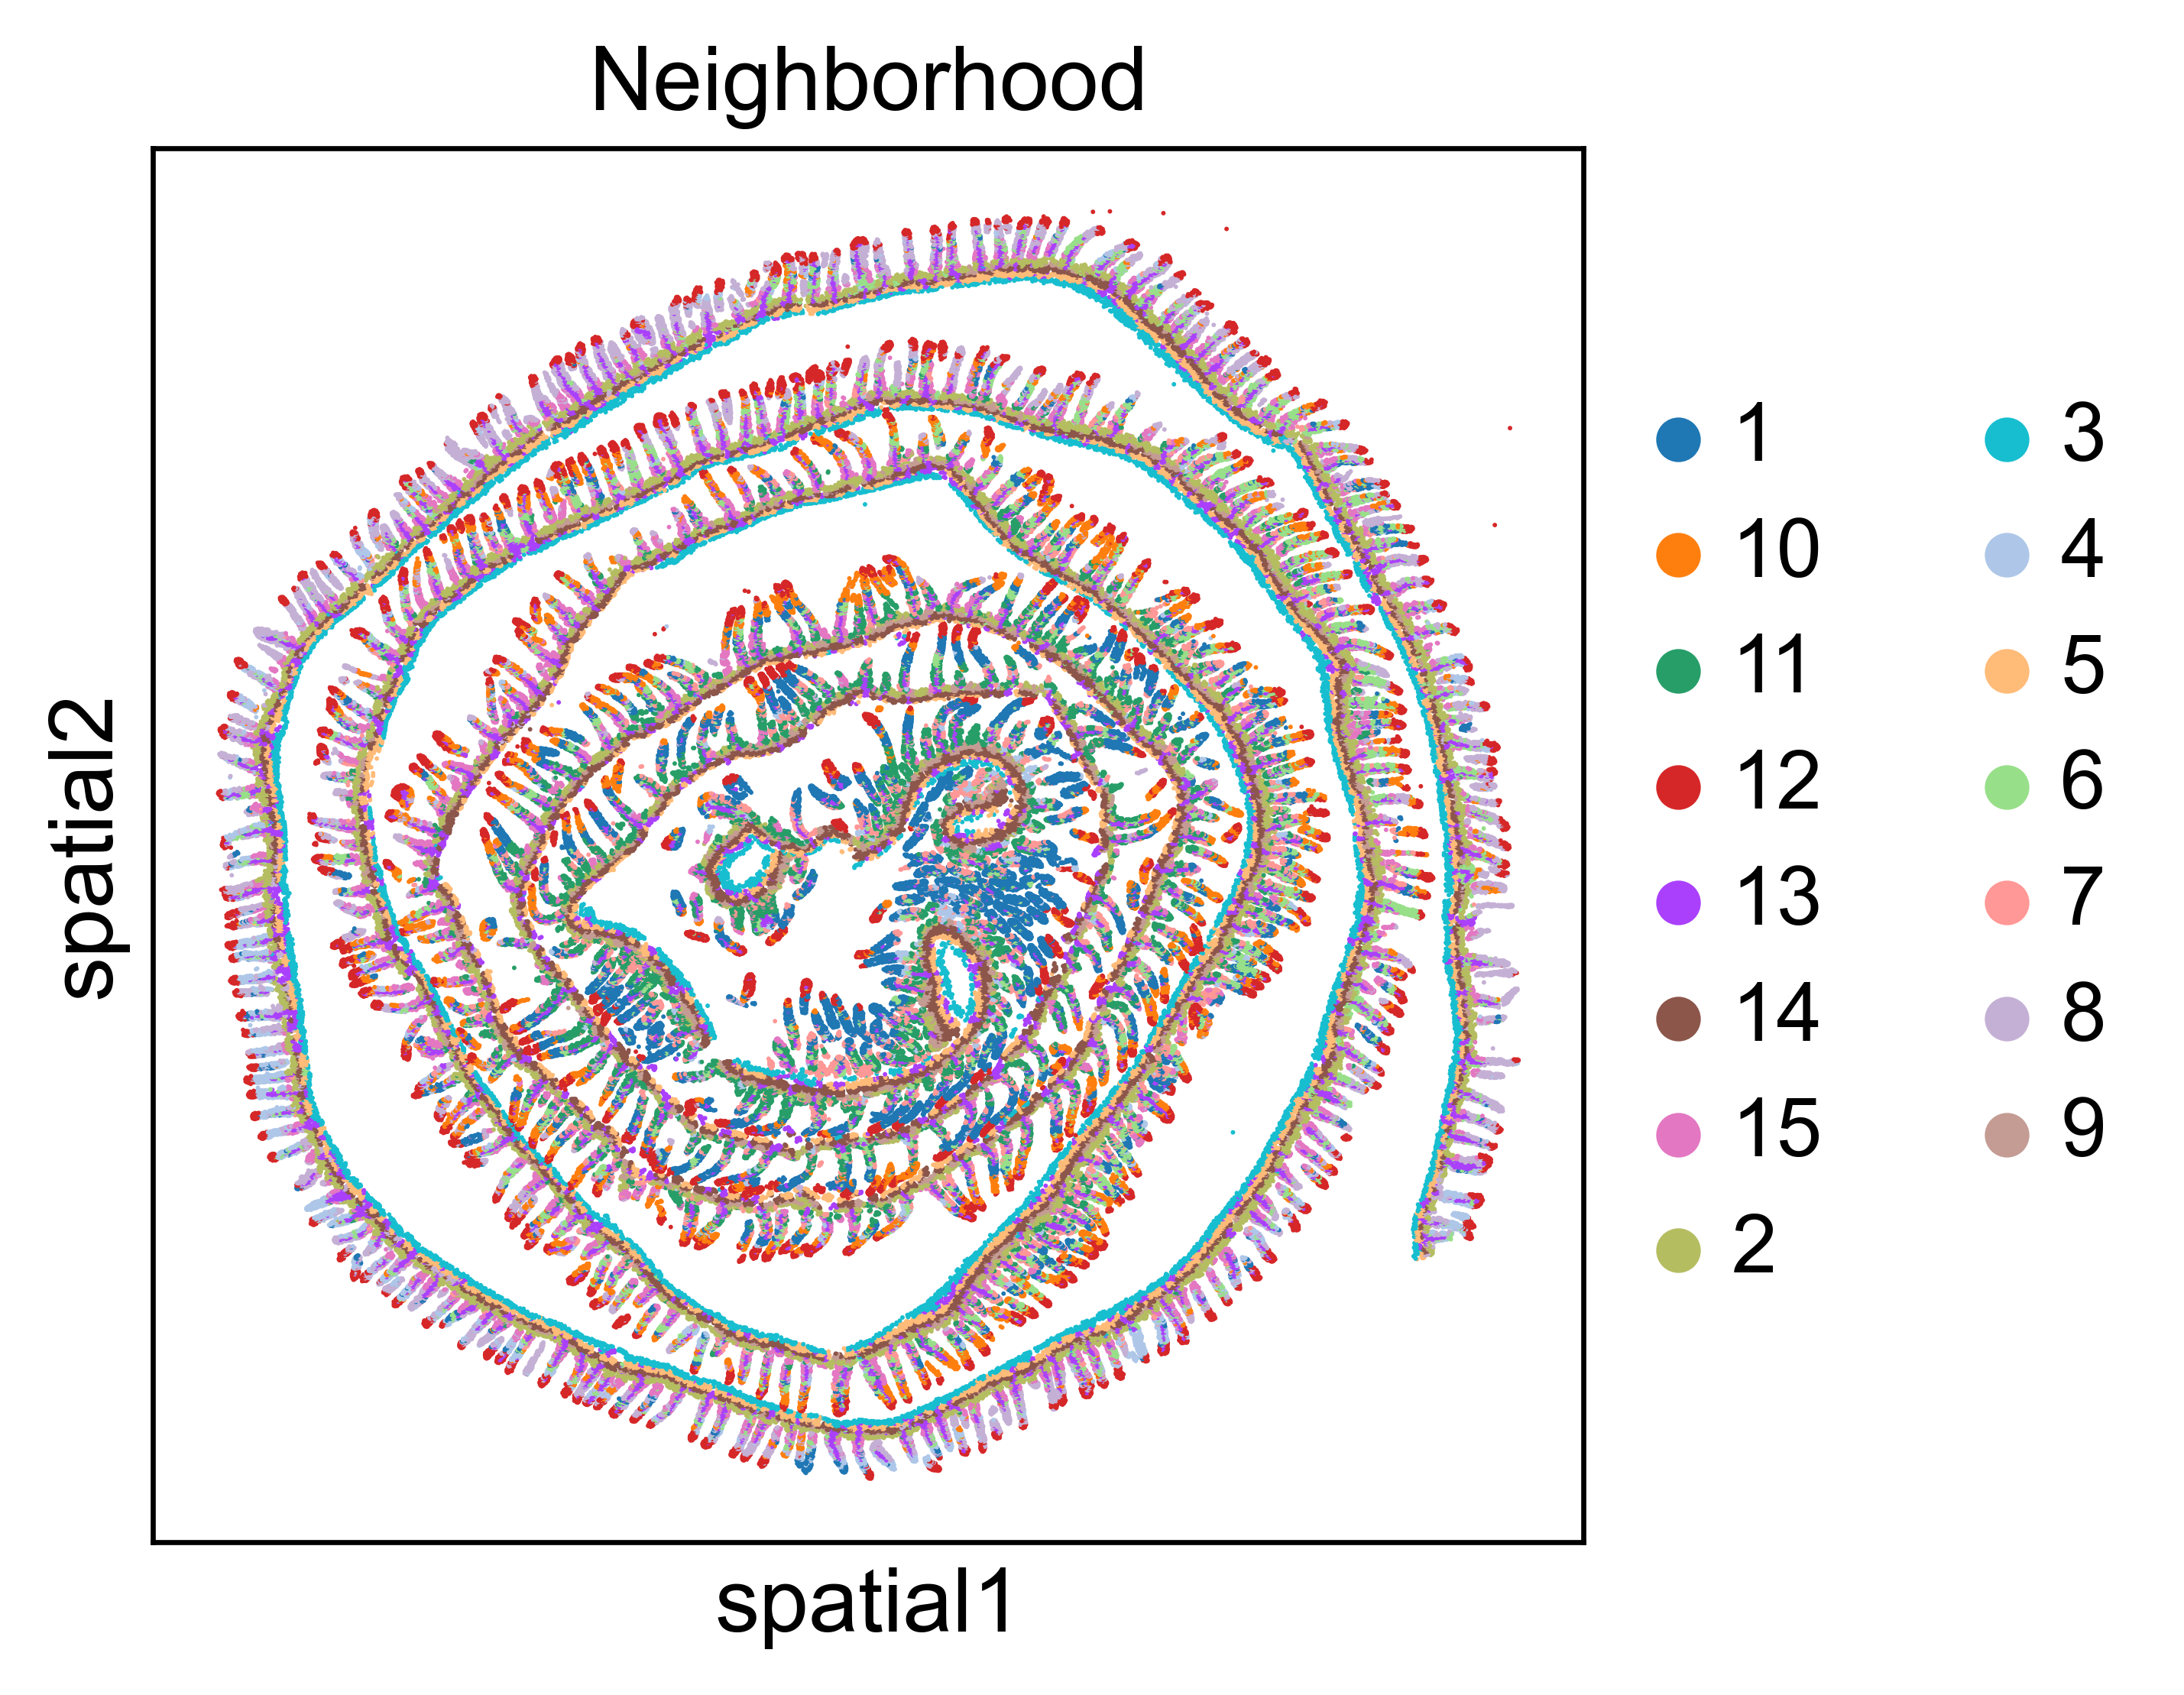

In [36]:
adata = sc.read(os.path.join(input_folders[-1], 'adatas', '04_tissue_cleared.h5ad'))
celltype_cluster = np.array(adata.obs.index.tolist())
base_dictionary = {}
for i in np.unique(celltype_cluster):
    base_dictionary[i] = 0
nneighbors = 10
list_of_arrays = []
spatial_points = np.array([adata.obsm['X_spatial'][:,0], adata.obsm['X_spatial'][:,1]]).T
tree = KDTree(spatial_points)
for i_bac in tqdm(range(len(celltype_cluster))):
    current_cell = celltype_cluster[i_bac]
    distances, neighbors = tree.query(spatial_points[i_bac], k=nneighbors)
    neighbors = list(neighbors)
    gene_array = np.array(np.sum(adata.X[np.array(neighbors), :], axis=0)).squeeze()
    list_of_arrays.append(gene_array)

X = pd.DataFrame(np.array(list_of_arrays)).astype(H.dtype)
W = model.transform(X)

topics_frame = pd.DataFrame(W)
topics_frame.columns = ['Topic '+str(i+1) for i in range(len(topics_frame.columns))]
topics_frame.index = adata.obs.index.tolist()
def zscore(column):
    return (column - column.mean()) / column.std()

# Apply the z-score function to each column in the dataframe
topics_frame = topics_frame.apply(zscore)
adata.obs.drop([i for i in adata.obs.columns if 'opic' in i], axis=1, inplace=True)
adata.obs = pd.concat([adata.obs, topics_frame], axis=1)
adata.obs['topic'] = pd.Categorical((np.argmax(topics_frame.values, axis = 1)+1).astype(str))

sc.set_figure_params(dpi=300)
sc.pl.embedding(adata, basis='spatial', color='topic', vmax=1, cmap='Blues', title='Neighborhood', size=2)

adata.write(os.path.join(data_dir, 'unrolling_meta', 'reference_neighborhoods.h5ad'))

### Now load the reference data and label the basal membrane neighborhoods. These will be used for the unrolling model

In [27]:
adata = sc.read(os.path.join(path_adata, 'adatas', '04_tissue_cleared.h5ad'))
all_spatial = adata.obsm['X_spatial']
try:
    adata.X = adata.X.A
except:
    print('Adata already in array format')

Adata already in array format


In [28]:
def plot_topic_scatter(adata, topic_column):
    # Extract data for plotting
    topics = adata.obs[topic_column]
    spatial_coords = adata.obsm['X_spatial']

    # Get unique topics
    unique_topics = topics.unique()

    # Create separate plots for each topic
    for topic in unique_topics:
        mask = topics == topic

        # Set up the plot for the current topic
        plt.figure(figsize=(2, 2), dpi=100)
        plt.scatter(spatial_coords[:, 0], spatial_coords[:, 1], color='lightgray', label='Other Cells', s=0.1, linewidths=0.1)
        plt.scatter(spatial_coords[mask, 0], spatial_coords[mask, 1], color='red', label=f'Topic: {topic}', alpha=0.8, s=0.1, linewidths=0.1)

        # Add labels and legend for the current plot
        plt.xlabel('X Spatial')
        plt.ylabel('Y Spatial')
        plt.title(f'Spatial Distribution of Topic: {topic}')
        plt.legend()
        plt.grid(False)

        # Save the plot with a unique filename for each topic
        plt.show()
        plt.close()

C:\Users\amonell\anaconda3_2\envs\scvi\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


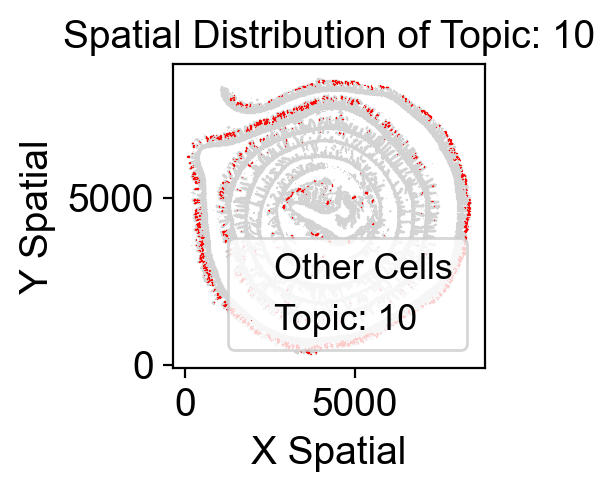

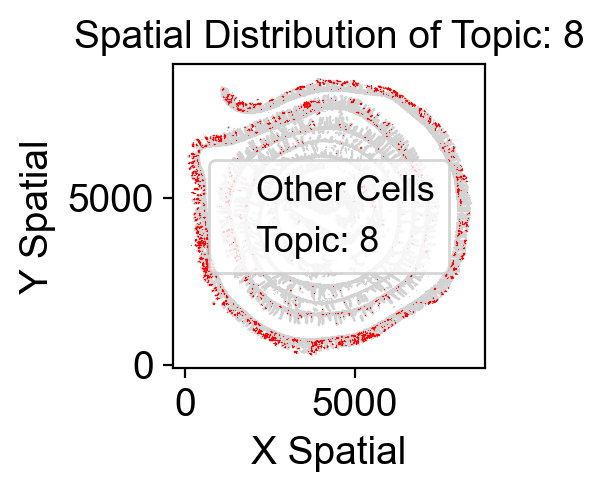

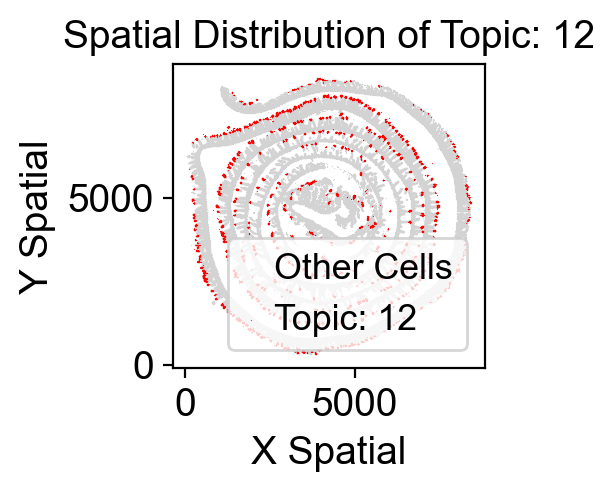

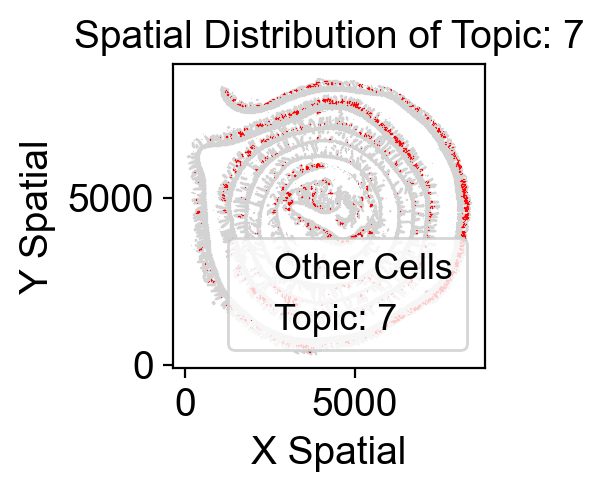

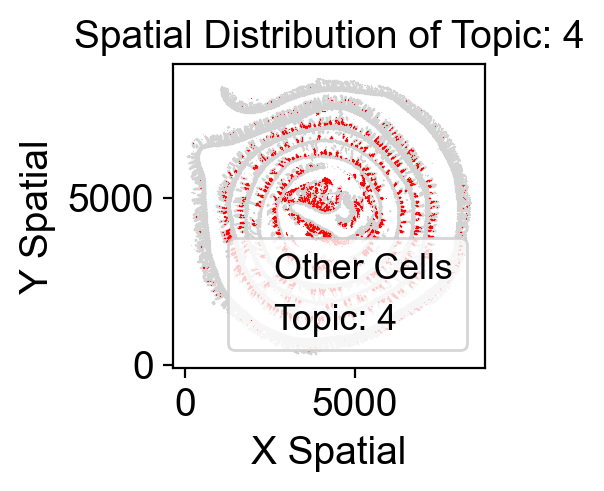

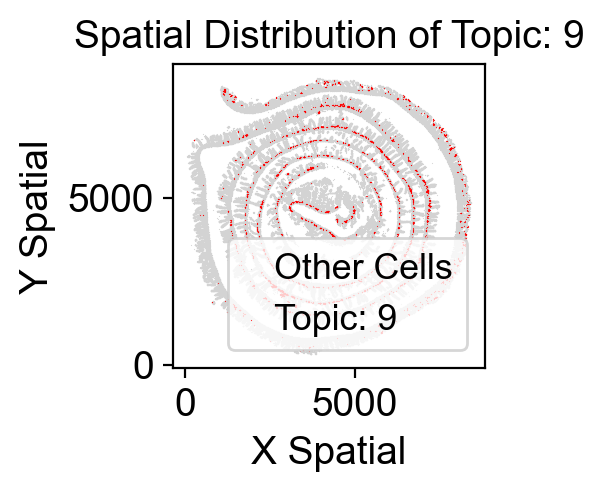

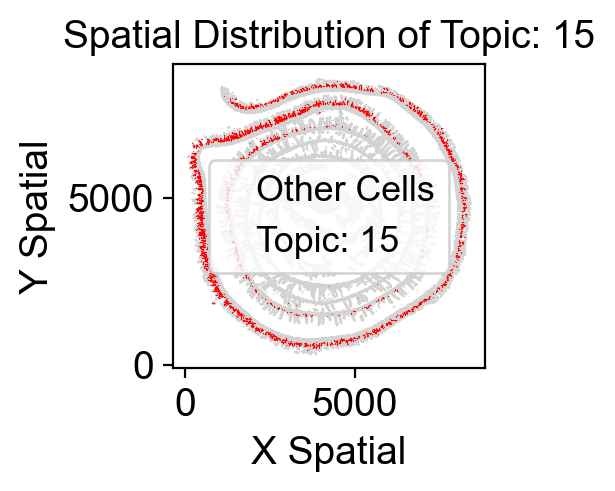

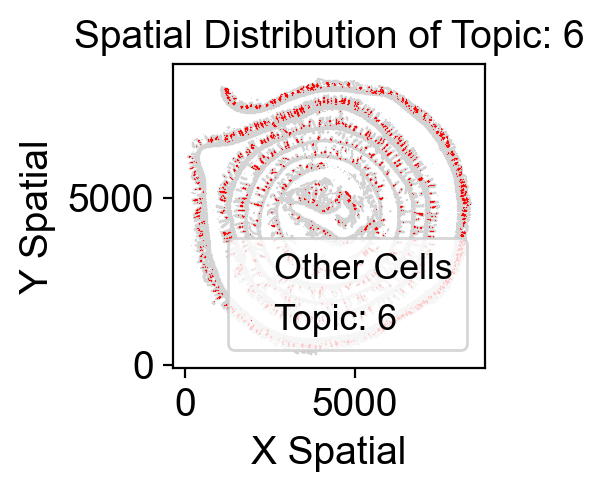

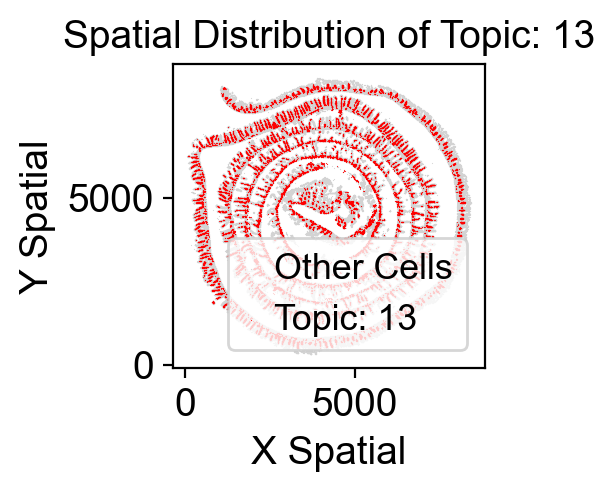

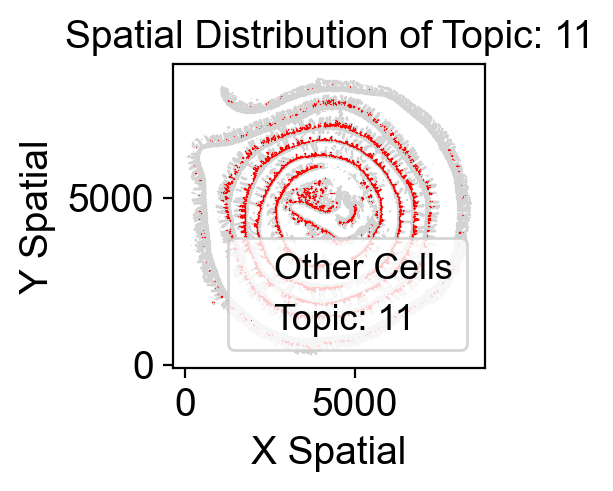

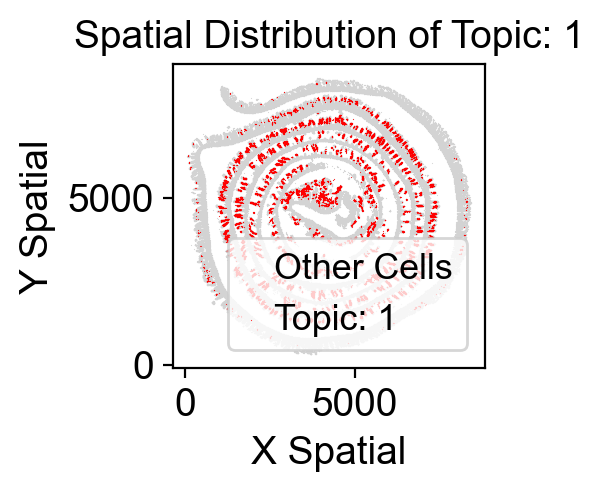

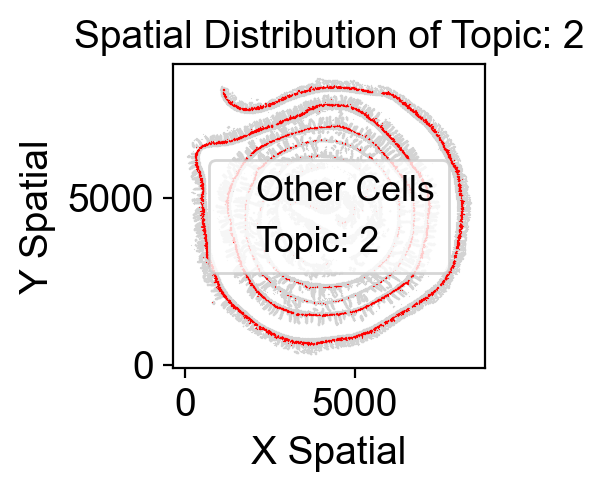

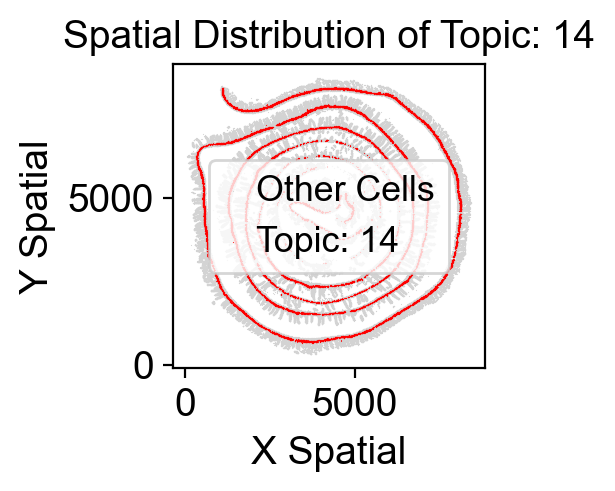

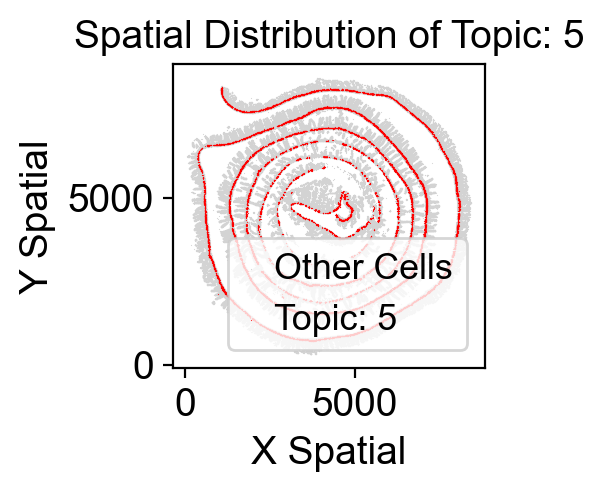

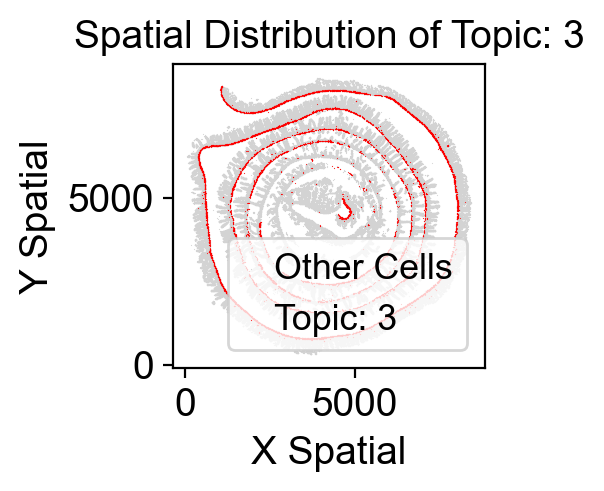

In [30]:
plot_topic_scatter(sc.read(os.path.join(input_folders[0], 'adatas', '04_part2_reference_neighborhoods.h5ad')), topic_column='topic')

Using the above topic highlight maps, put all neighborhoods appearing at the base of the swiss roll in the following list

In [31]:
topics_contain = ['14', '5', '3']

#### Save out the base topics, and we will unroll them in the next script

In [34]:
np.save(os.path.join(data_dir, 'unrolling_meta', 'base_topicas.npy'), np.array(topics_contain))